## Path sampling

This notebook contains the code for Example [TODO].

First, imports:

In [2]:
import jax
import jax.numpy as jnp
import sys 
sys.path.append('../src/')
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy

from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Brownian motion prior, brownian bridge posterior

[0.1, 0.5, 1.0]
s:  0.0
Train loss: 442171.40625
Test loss is 502400.46875
s:  0.1
Train loss: 5257.662109375
Test loss is 8995.33203125
s:  0.5
Train loss: 3193.7548828125
Test loss is 3605.203857421875


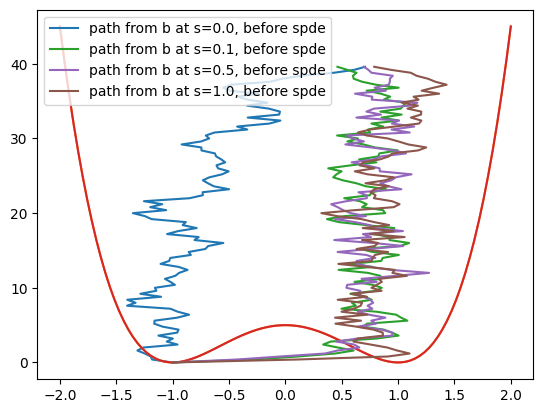

In [13]:
key = jax.random.key(0)
schedule = [0.1, 0.5, 1.0]
print(schedule)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 2000, 'batch_size' : 200}

# b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
b = lambda x, t: 0.0
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(1))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=lambda x: 0.0,
        b=b, 
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=False
    )



## Now use the learned b to generate new paths

In [17]:
from path_sampling import make_b


# use this if we do amortized nn
# b = make_b(schedule[:i], uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))


# xs : [batch_size, num_steps, ndims]
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-1,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))

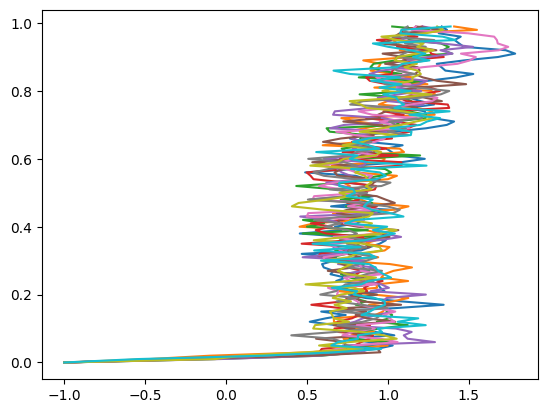

In [18]:
for path in xs:
    plt.plot(path, times[0])

# and compare to exact brownian bridge

(ignore the double well in the background - just a plotting artifact)

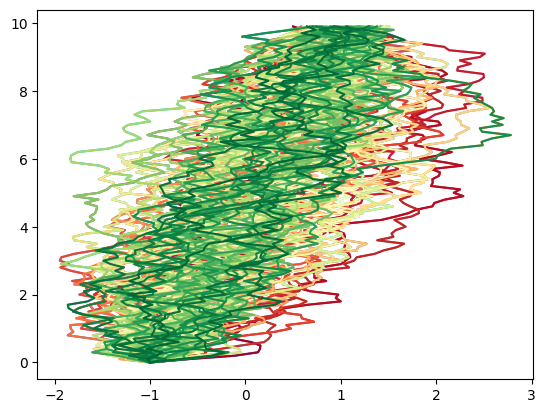

In [19]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (1 - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 100))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

# red to green colormap
# Create a colormap from red to green
cmap = plt.cm.RdYlGn
colors = cmap(np.linspace(0, 1, len(paths)))

# Plot each path with a color from the gradient
for i, (path, time) in enumerate(zip(paths, times)):
    plt.plot(path, time*10, color=colors[i])
    
# Plot the potential
# plt.plot(x, potential(x[:, None]), 'k--', alpha=0.7)  # Plot potential as dashed black line